<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/6_Find_Best_Traffic_Flow_Model_On_No_SPQ_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated without applying the SPQ rules.

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [2]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the path with the data that we are interested in
PATH = 'traffic_flow_without_SPQ.csv'

**Prepare the dataset**

In [5]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [6]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,11,0,0,0,...,0,0,11,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,101,39,44,27,0,21,...,0,0,0,0,0,9,17,24,0,0


In [7]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [8]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [9]:
# Print dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
67,108,5,0,20,2008-05-17 10:00:04,6
167,108,5,0,20,2008-05-17 10:30:04,6
267,108,5,0,20,2008-05-17 11:00:04,1
367,108,5,0,20,2008-05-17 11:30:04,6
467,108,5,0,20,2008-05-17 12:00:04,0
...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0
114735,168,547,99,2,2008-06-10 07:30:04,0
114835,168,547,99,2,2008-06-10 08:00:04,2
114935,168,547,99,2,2008-06-10 08:30:04,0


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [10]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [11]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [12]:
# Print traffic_flow dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
67,108,5,0,20,2008-05-17 10:00:04,6,10,5,17,0,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
167,108,5,0,20,2008-05-17 10:30:04,6,10,5,17,30,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
267,108,5,0,20,2008-05-17 11:00:04,1,11,5,17,0,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
367,108,5,0,20,2008-05-17 11:30:04,6,11,5,17,30,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
467,108,5,0,20,2008-05-17 12:00:04,0,12,5,17,0,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0,7,1,10,0,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114735,168,547,99,2,2008-06-10 07:30:04,0,7,1,10,30,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3
114835,168,547,99,2,2008-06-10 08:00:04,2,8,1,10,0,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114935,168,547,99,2,2008-06-10 08:30:04,0,8,1,10,30,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3


In [13]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


<Axes: >

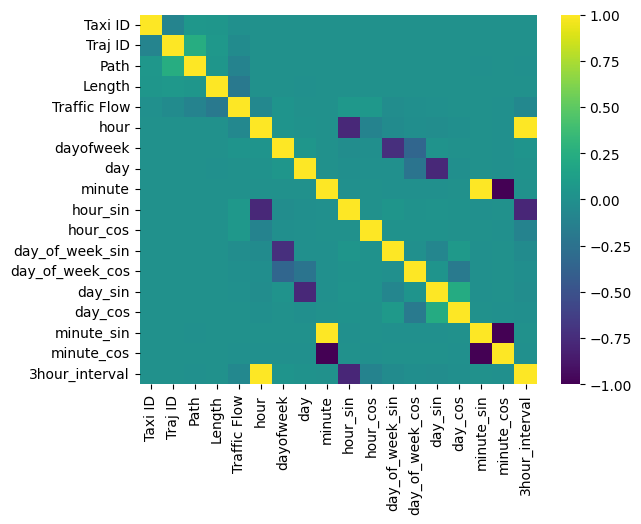

In [17]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [18]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Traffic Flow', 'hour', 'dayofweek', 'day', 'minute']

#### **Find the Optimum Sliding Window Length**

In [19]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [20]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

In [22]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [23]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [24]:
# Define Window Length
lookback = 2

In [25]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [26]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [27]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [28]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [29]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [30]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.33377	validation_1-rmse:25.35601
[1]	validation_0-rmse:24.92691	validation_1-rmse:23.94115
[2]	validation_0-rmse:23.56438	validation_1-rmse:22.59067
[3]	validation_0-rmse:22.41053	validation_1-rmse:21.44211
[4]	validation_0-rmse:21.47708	validation_1-rmse:20.50185
[5]	validation_0-rmse:20.54263	validation_1-rmse:19.58352
[6]	validation_0-rmse:19.73226	validation_1-rmse:18.78825
[7]	validation_0-rmse:19.09789	validation_1-rmse:18.15607
[8]	validation_0-rmse:18.67370	validation_1-rmse:17.72560
[9]	validation_0-rmse:18.19171	validation_1-rmse:17.24651
[10]	validation_0-rmse:17.78233	validation_1-rmse:16.83986
[11]	validation_0-rmse:17.41434	validation_1-rmse:16.47558
[12]	validation_0-rmse:17.19291	validation_1-rmse:16.24980
[13]	validation_0-rmse:16.90693	validation_1-rmse:15.97099
[14]	validation_0-rmse:16.63421	validation_1-rmse:15.70772
[15]	validation_0-rmse:16.39145	validation_1-rmse:15.47361
[16]	validation_0-rmse:16.20802	validation_1-rmse:15.29412
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [31]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [32]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [33]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.5897854430859555
RMSE score: 11.244848692424407


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [34]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [35]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [36]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [37]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [38]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [39]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 13s 40ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 2/50
100/100 [==============================] - 3s 32ms/step - loss: 0.0012 - val_loss: 8.0003e-04
Epoch 3/50
100/100 [==============================] - 2s 22ms/step - loss: 8.2907e-04 - val_loss: 7.2903e-04
Epoch 4/50
100/100 [==============================] - 5s 53ms/step - loss: 7.4611e-04 - val_loss: 7.3312e-04
Epoch 5/50
100/100 [==============================] - 2s 22ms/step - loss: 7.4290e-04 - val_loss: 7.1734e-04
Epoch 6/50
100/100 [==============================] - 1s 15ms/step - loss: 7.2056e-04 - val_loss: 6.6704e-04
Epoch 7/50
100/100 [==============================] - 8s 82ms/step - loss: 6.9766e-04 - val_loss: 6.5580e-04
Epoch 8/50
100/100 [==============================] - 2s 22ms/step - loss: 6.8970e-04 - val_loss: 6.6445e-04
Epoch 9/50
100/100 [==============================] - 8s 82ms/step - loss: 6.7148e-04 - val_loss: 6.5724e-04
Epoch 10/50
100/100 [=========

In [40]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1104/1104 [==============================] - 21s 19ms/step - loss: 6.0891e-04
Test Loss: 0.0006089056842029095


In [41]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1104/1104 [==============================] - 18s 16ms/step


Evaluate the LSTM model

In [42]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.996326525488251
RMSE LSTM score: 11.375643113655743


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [43]:
# Create dataframe with scores (length == 2)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [44]:
scores # length is 2

,Model,RMSE Score,MAE Score
0,XGBoost,11.244849,5.589785
1,LSTM,11.375643,5.996327


##### Sliding Window Length Equals to 3

In [45]:
# Define Window Length
lookback = 3

In [46]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [47]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [48]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [49]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [50]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.31825	validation_1-rmse:25.33947
[1]	validation_0-rmse:24.91338	validation_1-rmse:23.92436
[2]	validation_0-rmse:23.64675	validation_1-rmse:22.65146
[3]	validation_0-rmse:22.54059	validation_1-rmse:21.53920
[4]	validation_0-rmse:21.46262	validation_1-rmse:20.47992
[5]	validation_0-rmse:20.51899	validation_1-rmse:19.54975
[6]	validation_0-rmse:19.74280	validation_1-rmse:18.78122
[7]	validation_0-rmse:19.26068	validation_1-rmse:18.28933
[8]	validation_0-rmse:18.68121	validation_1-rmse:17.71804
[9]	validation_0-rmse:18.19245	validation_1-rmse:17.23315
[10]	validation_0-rmse:17.69070	validation_1-rmse:16.74884
[11]	validation_0-rmse:17.33605	validation_1-rmse:16.39723
[12]	validation_0-rmse:16.93313	validation_1-rmse:16.01865
[13]	validation_0-rmse:16.62464	validation_1-rmse:15.71876
[14]	validation_0-rmse:16.38831	validation_1-rmse:15.48697
[15]	validation_0-rmse:16.25116	validation_1-rmse:15.35008
[16]	validation_0-rmse:16.13254	validation_1-rmse:15.23142
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [51]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.57412	validation_1-rmse:24.73988
[1]	validation_0-rmse:23.66795	validation_1-rmse:22.91557
[2]	validation_0-rmse:21.98424	validation_1-rmse:21.32385
[3]	validation_0-rmse:20.50247	validation_1-rmse:19.90769
[4]	validation_0-rmse:19.19817	validation_1-rmse:18.66836
[5]	validation_0-rmse:18.07303	validation_1-rmse:17.60431
[6]	validation_0-rmse:17.09203	validation_1-rmse:16.68518
[7]	validation_0-rmse:16.24775	validation_1-rmse:15.90042
[8]	validation_0-rmse:15.51046	validation_1-rmse:15.20815
[9]	validation_0-rmse:14.88096	validation_1-rmse:14.62117
[10]	validation_0-rmse:14.34358	validation_1-rmse:14.11808
[11]	validation_0-rmse:13.88057	validation_1-rmse:13.67773
[12]	validation_0-rmse:13.48751	validation_1-rmse:13.32034
[13]	validation_0-rmse:13.15157	validation_1-rmse:13.01236
[14]	validation_0-rmse:12.87043	validation_1-rmse:12.75184
[15]	validation_0-rmse:12.63274	validation_1-rmse:12.54702
[16]	validation_0-rmse:12.42574	validation_1-rmse:12.36087
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [52]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [53]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.491319813031746
RMSE score: 11.136242291856826


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [54]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [55]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [56]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [57]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [58]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [59]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 25ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 2/50
100/100 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 7.1595e-04
Epoch 3/50
100/100 [==============================] - 3s 34ms/step - loss: 7.8631e-04 - val_loss: 7.3198e-04
Epoch 4/50
100/100 [==============================] - 3s 30ms/step - loss: 7.4048e-04 - val_loss: 6.7850e-04
Epoch 5/50
100/100 [==============================] - 6s 56ms/step - loss: 6.8507e-04 - val_loss: 6.6405e-04
Epoch 6/50
100/100 [==============================] - 1s 13ms/step - loss: 6.9409e-04 - val_loss: 6.5811e-04
Epoch 7/50
100/100 [==============================] - 5s 54ms/step - loss: 6.5739e-04 - val_loss: 6.5681e-04
Epoch 8/50
100/100 [==============================] - 8s 83ms/step - loss: 6.3765e-04 - val_loss: 6.4813e-04
Epoch 9/50
100/100 [==============================] - 7s 69ms/step - loss: 6.3411e-04 - val_loss: 6.4193e-04
Epoch 10/50
100/100 [==========

In [60]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1100/1100 [==============================] - 17s 16ms/step - loss: 6.2130e-04
Test Loss: 0.0006212979787960649


In [61]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1100/1100 [==============================] - 7s 6ms/step


Evaluate the LSTM model

In [62]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  6.061225177605044
RMSE LSTM score: 11.490816138592317


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [63]:
# Create dataframe with scores (length == 3)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [64]:
scores # length is 3

,Model,RMSE Score,MAE Score
0,XGBoost,11.136242,5.491320
1,LSTM,11.490816,6.061225


##### Sliding Window Length Equals to 4

In [66]:
lookback = 4

In [67]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [68]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [69]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [70]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [71]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.33325	validation_1-rmse:25.32994
[1]	validation_0-rmse:24.91628	validation_1-rmse:23.90495
[2]	validation_0-rmse:23.54780	validation_1-rmse:22.55298
[3]	validation_0-rmse:22.44950	validation_1-rmse:21.45117
[4]	validation_0-rmse:21.48625	validation_1-rmse:20.48691
[5]	validation_0-rmse:20.65325	validation_1-rmse:19.65184
[6]	validation_0-rmse:19.90347	validation_1-rmse:18.90688
[7]	validation_0-rmse:19.23245	validation_1-rmse:18.24297
[8]	validation_0-rmse:18.58664	validation_1-rmse:17.61819
[9]	validation_0-rmse:18.11528	validation_1-rmse:17.14901
[10]	validation_0-rmse:17.61194	validation_1-rmse:16.66400
[11]	validation_0-rmse:17.25076	validation_1-rmse:16.30686
[12]	validation_0-rmse:16.85591	validation_1-rmse:15.93092
[13]	validation_0-rmse:16.53240	validation_1-rmse:15.62116
[14]	validation_0-rmse:16.37283	validation_1-rmse:15.46178
[15]	validation_0-rmse:16.16404	validation_1-rmse:15.25912
[16]	validation_0-rmse:15.91350	validation_1-rmse:15.03037
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [72]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.60007	validation_1-rmse:24.73399
[1]	validation_0-rmse:23.70217	validation_1-rmse:22.93287
[2]	validation_0-rmse:22.03110	validation_1-rmse:21.32640
[3]	validation_0-rmse:20.55409	validation_1-rmse:19.93049
[4]	validation_0-rmse:19.26004	validation_1-rmse:18.69127
[5]	validation_0-rmse:18.13430	validation_1-rmse:17.63552
[6]	validation_0-rmse:17.15575	validation_1-rmse:16.70210
[7]	validation_0-rmse:16.30234	validation_1-rmse:15.90529
[8]	validation_0-rmse:15.56963	validation_1-rmse:15.22998
[9]	validation_0-rmse:14.93889	validation_1-rmse:14.64803
[10]	validation_0-rmse:14.40169	validation_1-rmse:14.16226
[11]	validation_0-rmse:13.93836	validation_1-rmse:13.73504
[12]	validation_0-rmse:13.53917	validation_1-rmse:13.36639
[13]	validation_0-rmse:13.20217	validation_1-rmse:13.05262
[14]	validation_0-rmse:12.91347	validation_1-rmse:12.79317
[15]	validation_0-rmse:12.66883	validation_1-rmse:12.57928
[16]	validation_0-rmse:12.45899	validation_1-rmse:12.39538
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [73]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [74]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.459147174339947
RMSE score: 11.124394557572444


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [75]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [76]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [77]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [78]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [79]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [80]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 13s 80ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 2/50
100/100 [==============================] - 7s 73ms/step - loss: 0.0011 - val_loss: 8.1844e-04
Epoch 3/50
100/100 [==============================] - 4s 41ms/step - loss: 8.3912e-04 - val_loss: 7.2886e-04
Epoch 4/50
100/100 [==============================] - 5s 50ms/step - loss: 7.6227e-04 - val_loss: 7.6153e-04
Epoch 5/50
100/100 [==============================] - 4s 45ms/step - loss: 7.1968e-04 - val_loss: 6.9824e-04
Epoch 6/50
100/100 [==============================] - 4s 42ms/step - loss: 7.0023e-04 - val_loss: 6.8882e-04
Epoch 7/50
100/100 [==============================] - 1s 14ms/step - loss: 6.8549e-04 - val_loss: 6.3507e-04
Epoch 8/50
100/100 [==============================] - 8s 78ms/step - loss: 6.5109e-04 - val_loss: 6.4367e-04
Epoch 9/50
100/100 [==============================] - 1s 14ms/step - loss: 6.6998e-04 - val_loss: 6.5303e-04
Epoch 10/50
100/100 [=========

In [81]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1097/1097 [==============================] - 24s 22ms/step - loss: 5.9808e-04
Test Loss: 0.000598083424847573


In [82]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1097/1097 [==============================] - 15s 13ms/step


Evaluate the LSTM model

In [83]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.738095604775638
RMSE LSTM score: 11.274098074085428


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [84]:
# Create dataframe with scores (length == 4)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [85]:
scores # length is 4

,Model,RMSE Score,MAE Score
0,XGBoost,11.124395,5.459147
1,LSTM,11.274098,5.738096


##### Sliding Window Length equals to 5

In [86]:
lookback = 5

In [87]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [88]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [89]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [90]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [91]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.38463	validation_1-rmse:25.36161
[1]	validation_0-rmse:24.98958	validation_1-rmse:23.95374
[2]	validation_0-rmse:23.77535	validation_1-rmse:22.73548
[3]	validation_0-rmse:22.57046	validation_1-rmse:21.55211
[4]	validation_0-rmse:21.62116	validation_1-rmse:20.60311
[5]	validation_0-rmse:20.77292	validation_1-rmse:19.75823
[6]	validation_0-rmse:19.99477	validation_1-rmse:18.98906
[7]	validation_0-rmse:19.25638	validation_1-rmse:18.27287
[8]	validation_0-rmse:18.69250	validation_1-rmse:17.71534
[9]	validation_0-rmse:18.12105	validation_1-rmse:17.16604
[10]	validation_0-rmse:17.69882	validation_1-rmse:16.74892
[11]	validation_0-rmse:17.29943	validation_1-rmse:16.35934
[12]	validation_0-rmse:16.98637	validation_1-rmse:16.05051
[13]	validation_0-rmse:16.65501	validation_1-rmse:15.73469
[14]	validation_0-rmse:16.41551	validation_1-rmse:15.50160
[15]	validation_0-rmse:16.27641	validation_1-rmse:15.36397
[16]	validation_0-rmse:16.08021	validation_1-rmse:15.17552
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [92]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.60878	validation_1-rmse:24.74500
[1]	validation_0-rmse:23.71343	validation_1-rmse:22.94210
[2]	validation_0-rmse:22.04160	validation_1-rmse:21.32908
[3]	validation_0-rmse:20.56560	validation_1-rmse:19.94464
[4]	validation_0-rmse:19.28785	validation_1-rmse:18.74641
[5]	validation_0-rmse:18.16747	validation_1-rmse:17.69916
[6]	validation_0-rmse:17.18877	validation_1-rmse:16.77764
[7]	validation_0-rmse:16.33800	validation_1-rmse:15.96371
[8]	validation_0-rmse:15.60745	validation_1-rmse:15.29027
[9]	validation_0-rmse:14.97728	validation_1-rmse:14.71428
[10]	validation_0-rmse:14.42656	validation_1-rmse:14.20058
[11]	validation_0-rmse:13.96104	validation_1-rmse:13.76737
[12]	validation_0-rmse:13.55775	validation_1-rmse:13.40239
[13]	validation_0-rmse:13.21397	validation_1-rmse:13.09045
[14]	validation_0-rmse:12.92591	validation_1-rmse:12.82424
[15]	validation_0-rmse:12.67833	validation_1-rmse:12.60917
[16]	validation_0-rmse:12.46442	validation_1-rmse:12.42445
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [93]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [94]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.448586204237637
RMSE score: 11.127999227733111


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [95]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [96]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [97]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [98]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [99]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [100]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 7s 16ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 2/50
100/100 [==============================] - 7s 66ms/step - loss: 0.0011 - val_loss: 7.9836e-04
Epoch 3/50
100/100 [==============================] - 2s 15ms/step - loss: 8.5743e-04 - val_loss: 8.4682e-04
Epoch 4/50
100/100 [==============================] - 1s 13ms/step - loss: 7.8347e-04 - val_loss: 6.8561e-04
Epoch 5/50
100/100 [==============================] - 8s 85ms/step - loss: 7.5454e-04 - val_loss: 6.7433e-04
Epoch 6/50
100/100 [==============================] - 3s 28ms/step - loss: 7.1003e-04 - val_loss: 6.5332e-04
Epoch 7/50
100/100 [==============================] - 1s 13ms/step - loss: 6.9727e-04 - val_loss: 6.5098e-04
Epoch 8/50
100/100 [==============================] - 2s 20ms/step - loss: 6.7419e-04 - val_loss: 6.5431e-04
Epoch 9/50
100/100 [==============================] - 6s 59ms/step - loss: 6.6700e-04 - val_loss: 6.4343e-04
Epoch 10/50
100/100 [==========

In [101]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1094/1094 [==============================] - 22s 20ms/step - loss: 5.9787e-04
Test Loss: 0.0005978747503831983


In [102]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1094/1094 [==============================] - 12s 10ms/step


Evaluate the LSTM model

In [103]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.665022869127137
RMSE LSTM score: 11.272127107360852


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [104]:
# Create dataframe with scores (length == 5)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [105]:
scores # length is 5

,Model,RMSE Score,MAE Score
0,XGBoost,11.127999,5.448586
1,LSTM,11.272127,5.665023


##### Sliding Window Length Equal to 6

In [107]:
lookback = 6

In [108]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [109]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [110]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [111]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [112]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.40344	validation_1-rmse:25.36476
[1]	validation_0-rmse:25.02736	validation_1-rmse:23.98399
[2]	validation_0-rmse:23.67206	validation_1-rmse:22.64769
[3]	validation_0-rmse:22.59682	validation_1-rmse:21.56759
[4]	validation_0-rmse:21.64452	validation_1-rmse:20.62003
[5]	validation_0-rmse:20.79683	validation_1-rmse:19.77646
[6]	validation_0-rmse:20.02042	validation_1-rmse:19.01186
[7]	validation_0-rmse:19.53891	validation_1-rmse:18.52689
[8]	validation_0-rmse:18.97219	validation_1-rmse:17.96793
[9]	validation_0-rmse:18.37882	validation_1-rmse:17.39806
[10]	validation_0-rmse:17.94241	validation_1-rmse:16.96624
[11]	validation_0-rmse:17.48029	validation_1-rmse:16.52630
[12]	validation_0-rmse:17.14544	validation_1-rmse:16.20049
[13]	validation_0-rmse:16.80739	validation_1-rmse:15.87921
[14]	validation_0-rmse:16.56098	validation_1-rmse:15.63649
[15]	validation_0-rmse:16.42058	validation_1-rmse:15.49779
[16]	validation_0-rmse:16.23392	validation_1-rmse:15.31803
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [113]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.62535	validation_1-rmse:24.74837
[1]	validation_0-rmse:23.73290	validation_1-rmse:22.96620
[2]	validation_0-rmse:22.06230	validation_1-rmse:21.38798
[3]	validation_0-rmse:20.59231	validation_1-rmse:19.98706
[4]	validation_0-rmse:19.31511	validation_1-rmse:18.78713
[5]	validation_0-rmse:18.19222	validation_1-rmse:17.74151
[6]	validation_0-rmse:17.21151	validation_1-rmse:16.82399
[7]	validation_0-rmse:16.36855	validation_1-rmse:16.04330
[8]	validation_0-rmse:15.62279	validation_1-rmse:15.34343
[9]	validation_0-rmse:14.99164	validation_1-rmse:14.74212
[10]	validation_0-rmse:14.44603	validation_1-rmse:14.23275
[11]	validation_0-rmse:13.97684	validation_1-rmse:13.80034
[12]	validation_0-rmse:13.57854	validation_1-rmse:13.43864
[13]	validation_0-rmse:13.23128	validation_1-rmse:13.13177
[14]	validation_0-rmse:12.93833	validation_1-rmse:12.87380
[15]	validation_0-rmse:12.68666	validation_1-rmse:12.64967
[16]	validation_0-rmse:12.45336	validation_1-rmse:12.43822
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [114]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [115]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.443752773204921
RMSE score: 11.0943428326627


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [116]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [117]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [118]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [119]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [120]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [121]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 19ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 2/50
100/100 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 8.6124e-04
Epoch 3/50
100/100 [==============================] - 5s 46ms/step - loss: 8.7822e-04 - val_loss: 7.3491e-04
Epoch 4/50
100/100 [==============================] - 5s 51ms/step - loss: 7.9434e-04 - val_loss: 7.3881e-04
Epoch 5/50
100/100 [==============================] - 7s 73ms/step - loss: 7.4504e-04 - val_loss: 6.6429e-04
Epoch 6/50
100/100 [==============================] - 4s 45ms/step - loss: 7.3837e-04 - val_loss: 6.4244e-04
Epoch 7/50
100/100 [==============================] - 7s 73ms/step - loss: 7.2213e-04 - val_loss: 6.9855e-04
Epoch 8/50
100/100 [==============================] - 5s 47ms/step - loss: 7.1362e-04 - val_loss: 6.5804e-04
Epoch 9/50
100/100 [==============================] - 6s 57ms/step - loss: 6.8074e-04 - val_loss: 6.3079e-04
Epoch 10/50
100/100 [==========

In [122]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1091/1091 [==============================] - 28s 26ms/step - loss: 6.0741e-04
Test Loss: 0.0006074067787267268


In [123]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1091/1091 [==============================] - 30s 27ms/step


Evaluate the LSTM model

In [124]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.610116016728147
RMSE LSTM score: 11.361633253338372


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [125]:
# Create dataframe with scores (length == 6)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [126]:
scores # length is 6

,Model,RMSE Score,MAE Score
0,XGBoost,11.094343,5.443753
1,LSTM,11.361633,5.610116
